In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
# preparing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# modeling and evaluating
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, accuracy_score


np.random.seed(123)

import acquire

# Goal: Find the main demographic driver for Telco churn.

<u> Demographics I'll be looking at:</u>

- Senior citizens
- Single customers
- Customers with Partners
- Customers with Dependants
- Customers with Partner & Dependants

<u> Subgroups to compare once main driver is found, if I want to get more specific: </u>
- Gender
- monthly charges
- tenure

### Notes: By looking at the above demographics I want to find:
1) Highest churned demographic group (of the above)
- Note: I will first need to look at the group as whole (all churned and which group had most churns)
- Note: Then I should consider churn rate based with each group (example: senior citizens that have and have not churned rate)

# Getting to know my data:

In [2]:
#I am using the excel version as it was easier to acquire from my computer
df= acquire.excel_file()
#looking at columns as there seems to be alot
df.columns

Index(['customer_id', 'gender', 'is_senior_citizen', 'partner', 'dependents',
       'phone_service', 'internet_service', 'contract_type', 'payment_type',
       'monthly_charges', 'total_charges', 'churn', 'tenure', 'is_auto',
       'is_female', 'has_churned', 'has_phone', 'has_internet',
       'has_phone_internet', 'partner_dependants', 'calculated_monthly_avg',
       'validate', 'phone_service_type', 'internet_service_type',
       'contract_type.1', 'rounded_tenure', 'service_type', 'tenure_bins'],
      dtype='object')

In [3]:
#checking out dytpes
df.dtypes

customer_id                object
gender                     object
is_senior_citizen         float64
partner                    object
dependents                 object
phone_service             float64
internet_service          float64
contract_type             float64
payment_type               object
monthly_charges           float64
total_charges             float64
churn                      object
tenure                    float64
is_auto                     int64
is_female                    bool
has_churned                  bool
has_phone                    bool
has_internet                 bool
has_phone_internet           bool
partner_dependants          int64
calculated_monthly_avg     object
validate                   object
phone_service_type         object
internet_service_type      object
contract_type.1            object
rounded_tenure              int64
service_type               object
tenure_bins                object
dtype: object

<b><u>Takeaways:</b></u>
- I can already see that later down the road, I am going to want to change certain columns from object to float or bool so that I can have numbers to work with in my models those A or B/Yes or No columns
- I know my target (y) will be churn...again, after exploring, I want to change that to a bool

In [4]:
#it looks like I will want to fillna the the total_charges. Because it is a total charge, I am going to use mean (or average) of the total charges to fill those in.
df.isnull().sum()

customer_id                0
gender                     0
is_senior_citizen          0
partner                    0
dependents                 0
phone_service              0
internet_service           0
contract_type              0
payment_type               0
monthly_charges            0
total_charges             11
churn                      0
tenure                     0
is_auto                    0
is_female                  0
has_churned                0
has_phone                  0
has_internet               0
has_phone_internet         0
partner_dependants         0
calculated_monthly_avg     0
validate                   0
phone_service_type         0
internet_service_type      0
contract_type.1            0
rounded_tenure             0
service_type               0
tenure_bins                0
dtype: int64

In [5]:
#let's fill in those NaNs
total_mean=df.total_charges.mean()
df['total_charges'].fillna(value=total_mean, inplace=True)

df.isnull().sum()

customer_id               0
gender                    0
is_senior_citizen         0
partner                   0
dependents                0
phone_service             0
internet_service          0
contract_type             0
payment_type              0
monthly_charges           0
total_charges             0
churn                     0
tenure                    0
is_auto                   0
is_female                 0
has_churned               0
has_phone                 0
has_internet              0
has_phone_internet        0
partner_dependants        0
calculated_monthly_avg    0
validate                  0
phone_service_type        0
internet_service_type     0
contract_type.1           0
rounded_tenure            0
service_type              0
tenure_bins               0
dtype: int64

In [6]:
#for senior citizen demographics: 
df.is_senior_citizen.value_counts()

#TAKE AWAYS: Senior-citizens customers make up 19% of Telco customers
           # 59 or younger customers make up 81% of Telco customers

0.0    5907
1.0    1142
Name: is_senior_citizen, dtype: int64

In [7]:
#for clients with partner and/or dependants demographics: 
#note: 0= single |  3= has partner AND dependants | 2= has dependants  | 1= has partner
df.partner_dependants.value_counts()

#Takeaways: Singles represent 47% of Telco customers
          # Families represent 25% of Telco customers
          # Parteners represent 23% of Telco customers
          # Single parents represent 5% of Telco customers

0    3281
3    1754
1    1653
2     361
Name: partner_dependants, dtype: int64

In [8]:
#for gender demographics:
df.gender.value_counts()

#Takeaways: Males represent 50% of Telco customers
          # Females represent 50% of Telco customers

Male      3558
Female    3491
Name: gender, dtype: int64

In [9]:
#Encoding data for later churn use (as right now it is an object and I need numeric for models)
# First I create a new dataframe that holds my encoded columns.

churn_dummies = pd.get_dummies(df.churn, drop_first=True)
churn_dummies.sample(5)

,Yes
976,0
5998,0
1364,0
6876,0
1556,0


In [10]:
# Then I add my encoded columns back onto my original dataframe.

df = pd.concat([df, churn_dummies], axis=1)

In [11]:
#Let's look at the charts for these demographic customers:
##specifically high percentage groups: 59 or younger | Singles | (and maybe compare to gender?)

## Questions I'm thinking:
-  What do I think my drivers are? 
-  Why?
-  How can I look in/prove that?
-  Are there needed subgroups that I can use later on?
-  What can I get rid of?

Q: What/WHO do I think my drivers are?
- I know from the past that <b>non-automated accounts </b>were a major part of the churn, but I never found out WHO these people were.

#### <u>I want to know:</u>
- Their age, gender, and relationship status [get to know our churns and the probability of a certain demographic leaving]

Q: <i>Why would they churn?</i>
- Is it due only to their non-automated accounts or is there another reason within who they are?

Q: <i>How could I look at this?</i>
- Categorically: churn vs. demographic cateogries w/ chi2 tests and t-tests
- Visually: graphs, charts and accuracy rates in model

Q: <i>What subgroups do I think I will need to help me test churn and demographics?</i>
  - monthly charges (if I find a driver, I'd like to see a possible why within $$ the pay)
  - account types
  - non-automated accounts (to compare to last presentations findings)

## Next Steps:
- ✅ Creating range columns (for upcoming hypothesis testing) 
- ✅ PreProcessing Data (encoding any needed data)
- ✅ Prepping and splitting data to Explore and later Train on
- ✅ Explore some charts of the data (histograms comparing demographics)

In [12]:
#creating the columns for range in the statistical table of df
##used this great function from Faith Kane
def col_range(df):
    stats_df = df.describe().T
    stats_df['range'] = stats_df['max'] - stats_df['min']
    return stats_df

In [13]:
col_range(df)

,count,mean,std,min,25%,50%,75%,max,range
is_senior_citizen,7049.0,0.162009,0.368485,0.00,0.000000,0.000000,0.000000,1.000000,1.000000
phone_service,7049.0,1.324585,0.642709,0.00,1.000000,1.000000,2.000000,2.000000,2.000000
internet_service,7049.0,1.222585,0.779068,0.00,1.000000,1.000000,2.000000,2.000000,2.000000
contract_type,7049.0,0.690878,0.833757,0.00,0.000000,0.000000,1.000000,2.000000,2.000000
monthly_charges,7049.0,64.747014,30.099460,18.25,35.450000,70.350000,89.850000,118.750000,100.500000
total_charges,7049.0,2283.043883,2264.752583,18.80,402.500000,1400.300000,3784.000000,8684.800000,8666.000000
tenure,7049.0,32.379866,24.595524,0.00,8.733456,28.683425,55.229399,79.341772,79.341772
is_auto,7049.0,0.435806,0.495897,0.00,0.000000,0.000000,1.000000,1.000000,1.000000
partner_dependants,7049.0,1.083416,1.226883,0.00,0.000000,1.000000,2.000000,3.000000,3.000000
rounded_tenure,7049.0,32.374805,24.596637,0.00,9.000000,29.000000,55.000000,79.000000,79.000000


## Preparing Data:

In [14]:
# Preparing and Seperating the Data:
#- Separating the split data to begin exploration and hypothesis testing
##note: this will be added to the prepare.py file
def telco_split(df):
    '''
    This function takes in Telco data from the acquire.py file,
    performs a split and stratifies on churn.
    Returns train, validate, and test dfs.
    '''
    train_validate, test = train_test_split(df, test_size=.2, 
                                        random_state=123, 
                                        stratify=df.churn)
    train, validate = train_test_split(train_validate, test_size=.3, 
                                   random_state=123, 
                                   stratify=train_validate.churn)
    return train, validate, test

In [15]:
##note: this will be added to the prepare.py file
def prep_telco(df):
    '''
    This function takes in the Telco df(via acquire.py).
    It drops the species_id column and renames species_name to species, 
    Performs a 3-way split stratified on churn, and
    Returns train, validate, and test dataframes.
    '''
    # drop and rename columns
    df = df.drop(columns='customer_id').rename(columns={'has_churned': 'Churned_Customers'})
    
    # split dataframe into train, validate, and test
    train, validate, test = telco_split(df)
    
    return train, validate, test

In [16]:
train, validate, test = prep_telco(df)

print(f'train -> {train.shape}')
print(f'validate -> {validate.shape}')
print(f'test -> {test.shape}')

train -> (3947, 28)
validate -> (1692, 28)
test -> (1410, 28)


# Hypothesis & Charts Exploration:

## Churn vs. Partnerships (number of people on accounts)
I want to take some time to explore the relationships between churn and the Telco demographics. 
I'll be using ChiSquare, as this Hypothesis test works well with two categorical values. 
I also will be using barplots to visually show these relations...if any. :)

alpha: 0.05

* H0: There is NO relationship between churn and partnerships (or # of people on account)
* Ha: There IS a relationship between churn and partnerships.

In [17]:
#Calculating ChiSquare of categorical demographics (churn + partner_dependants)
n = train.shape[0]

churn_proportions = train.churn.value_counts() / n
churn_proportions

No     0.734735
Yes    0.265265
Name: churn, dtype: float64

In [18]:
partner_proportions = train.partner_dependants.value_counts() / n
partner_proportions

0    0.458829
3    0.255384
1    0.234102
2    0.051685
Name: partner_dependants, dtype: float64

In [19]:
#creating a function for the expected value to include in ChiSquare
expected = pd.DataFrame()

for churn_group, t_prop in churn_proportions.iteritems():
    for partner_group, d_prop in partner_proportions.iteritems():
        expected.loc[partner_group, churn_group] = t_prop * d_prop

expected.sort_index(inplace=True)
expected

,No,Yes
0,0.337118,0.121711
1,0.172003,0.062099
2,0.037975,0.013710
3,0.187640,0.067744


In [20]:
# Chi squared with un-encoded categorical columns
# Null hypothesis: churn rate has no relation to partnerships of customers
# Alternative hypothesis: there is a relationship between churn rate and partnerships of customers
alpha = 0.05
observed = pd.crosstab(train.churn, train.partner_dependants)
chi2, p, degf, expected = stats.chi2_contingency(observed)
print(f"The p-value is {p}")
if p < alpha:
    print("Sufficient evidence is present to reject the null hypothesis")
else:
    print("Insufficient evidence to reject the null")
    print("Evidence seems to support the claim that partnership and churn are independent")

The p-value is 3.9152166914300486e-24
Sufficient evidence is present to reject the null hypothesis


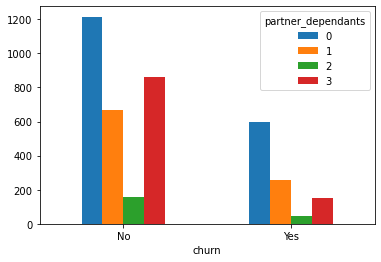

In [21]:
#let's look at the numbers visually
barplot = observed.plot.bar(rot=0)

### Take Aways:
Percentage of churns per partnership/relationship category:
- <b> 0: Single customers: 33% churned</b>
- 1: Partnered customers: 28% churned
- 2: Single Parent customers: 22% churned
- 3: Family plan customers: 15% churned
<br>
<br>
* There IS a relationship between how many partnerships and number of household numbers to churn rate.
* Single customers are more likely to churn than any other relationship demographics.
* Family plan customers stay at a higher rate than any onther demographic.

##########################################################################

## Churn vs. Gender:

* H0: There is NO relationship between churn and gender.
* Ha: There IS a relationship between churn and gender.

In [22]:
#Calculating ChiSquare of categorical demographics (churn + gender)
n = train.shape[0]

churn_proportions = train.churn.value_counts() / n
churn_proportions

No     0.734735
Yes    0.265265
Name: churn, dtype: float64

In [23]:
gender_proportions = train.gender.value_counts() / n
gender_proportions

Male      0.509754
Female    0.490246
Name: gender, dtype: float64

In [24]:
expected = pd.DataFrame()

for churn_group, t_prop in churn_proportions.iteritems():
    for gender_group, g_prop in gender_proportions.iteritems():
        expected.loc[gender_group, churn_group] = t_prop * g_prop

expected.sort_index(inplace=True)
expected

,No,Yes
Female,0.360201,0.130045
Male,0.374534,0.135220


In [25]:
# Chi squared with un-encoded categorical columns
# Null hypothesis: churn rate has no relation to gender
# Alternative hypothesis: there is a relationship between churn rate and gender
alpha = 0.05
observed = pd.crosstab(train.churn, train.gender)
chi2, p, degf, expected = stats.chi2_contingency(observed)
print(f"The p-value is {p}")
if p < alpha:
    print("Sufficient evidence is present to reject the null hypothesis")
else:
    print("Insufficient evidence to reject the null")
    print("Evidence seems to support the claim that gender and churn are independent")

The p-value is 0.7612557822850128
Insufficient evidence to reject the null
Evidence seems to support the claim that gender and churn are independent


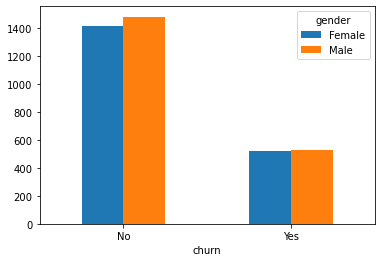

In [26]:
#let's look at the numbers visually
barplot = observed.plot.bar(rot=0)

### Take Aways:
Both Genders churned at almost the same rate within their own categories:
- <b>Female customers: 27% churned</b>
- Male customers: 26% churned
<br>
<br>

### The data shows that there really isn't any relationship between gender and customer churn rate.

##########################################################################

## Churn vs. Is Senior Citizen?

* H0: There is NO relationship between churn and customer being a senior citizen.
* Ha: There IS a relationship between churn and customer being a senior citizen.

In [27]:
#Calculating ChiSquare of categorical demographics (churn + is_senior_citizen)
n = train.shape[0]

churn_proportions = train.churn.value_counts() / n
churn_proportions

No     0.734735
Yes    0.265265
Name: churn, dtype: float64

In [28]:
age_proportions = train.is_senior_citizen.value_counts() / n
age_proportions

0.0    0.841905
1.0    0.158095
Name: is_senior_citizen, dtype: float64

In [29]:
expected = pd.DataFrame()

for churn_group, t_prop in churn_proportions.iteritems():
    for age_group, g_prop in age_proportions.iteritems():
        expected.loc[age_group, churn_group] = t_prop * g_prop

expected.sort_index(inplace=True)
expected

,No,Yes
0.0,0.618577,0.223328
1.0,0.116158,0.041937


In [30]:
# Chi squared with un-encoded categorical columns
# Null hypothesis: churn rate has no relation to senior citizen customers
# Alternative hypothesis: there is a relationship between churn rate and senior citizens
alpha = 0.05
observed = pd.crosstab(train.churn, train.is_senior_citizen)
chi2, p, degf, expected = stats.chi2_contingency(observed)
print(f"The p-value is {p}")
if p < alpha:
    print("Sufficient evidence is present to reject the null hypothesis")
else:
    print("Insufficient evidence to reject the null")
    print("Evidence seems to support the claim that senior_citizens and churn are independent")

The p-value is 9.950129712000579e-20
Sufficient evidence is present to reject the null hypothesis


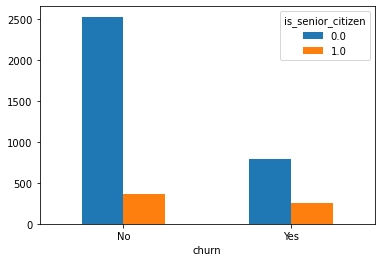

In [31]:
#let's look at the numbers visually
barplot = observed.plot.bar(rot=0)

### Take Aways:
From first glance, because of the low amount of Senior Citizen data count, it looks like customers 59 and younger have more churns. By numbers, YES, 59 and younger DO have more churn, but <b>by churn rate based on its own category, Senior Citizens have the highest churn rate.</b>
- <b>Senior Citizens: 41% churned</b>
- 59 and younger customers: 24% churned

As the p-value shows, in the case that the null Hypothesis is that churn and is_senior_citizen as NO relation,
We would reject the nully Hypothesis as they clearly relate. 

##########################################################################

### NEXT STEPS: 
- It's clear that our drivers for demographics is single and senior citizen customers.
- Using these two key drivers, it's time to compare to subcategories:
        * ✅ non-automated accounts
        * ✅ account types
        * ✅ internet service types

## Non-automated accounts vs. Is Senior Citizen:

* H0: There is NO relationship between non-auto accounts and customer being a senior citizen.
* Ha: There IS a relationship between non-auto accounts and customer being a senior citizen.

In [32]:
#taking a look at how many accounts are automated
train.is_auto.value_counts()

0    2173
1    1774
Name: is_auto, dtype: int64

In [33]:
#Calculating ChiSquare of categorical demographics (automated accounts + is_senior_citizen)
n = train.shape[0]

autoaccts_proportions = train.is_auto.value_counts() / n
autoaccts_proportions

0    0.550545
1    0.449455
Name: is_auto, dtype: float64

In [34]:
senior_proportions = train.is_senior_citizen.value_counts() / n
senior_proportions

0.0    0.841905
1.0    0.158095
Name: is_senior_citizen, dtype: float64

In [35]:
expected = pd.DataFrame()

for auto_group, t_prop in autoaccts_proportions.iteritems():
    for senior_group, g_prop in senior_proportions.iteritems():
        expected.loc[senior_group, auto_group] = t_prop * g_prop

expected.sort_index(inplace=True)
expected

,0,1
0.0,0.463506,0.378399
1.0,0.087038,0.071057


In [36]:
# Chi squared with un-encoded categorical columns
alpha = 0.05
observed = pd.crosstab(train.is_auto, train.is_senior_citizen)
chi2, p, degf, expected = stats.chi2_contingency(observed)
print(f"The p-value is {p}")
if p < alpha:
    print("Sufficient evidence is present to reject the null hypothesis")
else:
    print("Insufficient evidence to reject the null")
    print("Evidence seems to support the claim that senior citizens and auto accounts are independent")

The p-value is 0.7951549501754155
Insufficient evidence to reject the null
Evidence seems to support the claim that senior citizens and auto accounts are independent


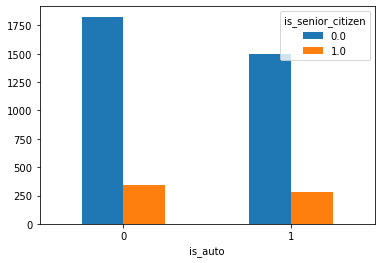

In [37]:
#let's look at the numbers visually
barplot = observed.plot.bar(rot=0)

### Take Aways:
* There IS a relationship between senior citizens and having non-automated accounts.
* The above barplot shows that a large majority of senior citizens actually do have non-automated accounts.
* (This bar plot looks also reminiscent of the is_senior citizen and churn plots).

##########################################################################

## Non-automated accounts vs. Singles (using Partner/Dependant variable):

* H0: There is NO relationship between non-auto accounts and customer being single.
* Ha: There IS a relationship between non-auto accounts and customer being single.

In [38]:
#Calculating ChiSquare of categorical demographics (automated accounts + singles)
n = train.shape[0]

autoaccts_proportions = train.is_auto.value_counts() / n
autoaccts_proportions

0    0.550545
1    0.449455
Name: is_auto, dtype: float64

In [39]:
#NOTE: remember, Singles is represented as 0 below:
singles_proportions = train.partner_dependants.value_counts() / n
singles_proportions

0    0.458829
3    0.255384
1    0.234102
2    0.051685
Name: partner_dependants, dtype: float64

In [40]:
expected = pd.DataFrame()

for auto_group, t_prop in autoaccts_proportions.iteritems():
    for singles_group, g_prop in singles_proportions.iteritems():
        expected.loc[singles_group, auto_group] = t_prop * g_prop

expected.sort_index(inplace=True)
expected

,0,1
0,0.252606,0.206223
1,0.128884,0.105218
2,0.028455,0.023230
3,0.140600,0.114784


In [41]:
# Chi squared with un-encoded categorical columns
alpha = 0.05
observed = pd.crosstab(train.is_auto, train.partner_dependants)
chi2, p, degf, expected = stats.chi2_contingency(observed)
print(f"The p-value is {p}")
if p < alpha:
    print("Sufficient evidence is present to reject the null hypothesis")
else:
    print("Insufficient evidence to reject the null")
    print("Evidence seems to support the claim that single customers and non-auto accounts are independent")

The p-value is 7.53789941507099e-21
Sufficient evidence is present to reject the null hypothesis


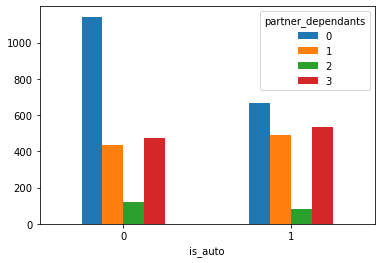

In [42]:
#let's look at the numbers visually
barplot = observed.plot.bar(rot=0)

### Take Aways:
* There IS a relationship between singles having non-automated accounts.
* The above barplot shows that a large majority of singles actually do have non-automated accounts.

##########################################################################

## Internet type accounts vs. Is Senior Citizen:

Seeing what kind of internet accounts most senior citizens have.

* H0: There is NO relationship between internet type of accounts and customer being a senior citizen.
* Ha: There IS a relationship between internet type of and customer being a senior citizen.

A reminder of what this column is showing:
* 2 = Fiber optic
* 1 = DSL
* 0 = No internet service

In [43]:
train.internet_service.value_counts()

2.0    1757
1.0    1347
0.0     843
Name: internet_service, dtype: int64

In [44]:
#Calculating ChiSquare of categorical demographics (automated accounts + singles)
n = train.shape[0]

internet_service_proportions = train.internet_service.value_counts() / n
internet_service_proportions

2.0    0.445148
1.0    0.341272
0.0    0.213580
Name: internet_service, dtype: float64

In [45]:
senior_proportions = train.is_senior_citizen.value_counts() / n
senior_proportions

0.0    0.841905
1.0    0.158095
Name: is_senior_citizen, dtype: float64

In [46]:
expected = pd.DataFrame()

for internet_group, t_prop in internet_service_proportions.iteritems():
    for senior_group, g_prop in senior_proportions.iteritems():
        expected.loc[senior_group, internet_group] = t_prop * g_prop

expected.sort_index(inplace=True)
expected

,2.0,1.0,0.0
0.0,0.374773,0.287319,0.179814
1.0,0.070376,0.053953,0.033766


In [47]:
# Chi squared with un-encoded categorical columns
alpha = 0.05
observed = pd.crosstab(train.internet_service, train.is_senior_citizen)
chi2, p, degf, expected = stats.chi2_contingency(observed)
print(f"The p-value is {p}")
if p < alpha:
    print("Sufficient evidence is present to reject the null hypothesis")
else:
    print("Insufficient evidence to reject the null")
    print("Evidence seems to support the claim that senior customers and internet account types are independent")

The p-value is 3.783837682147854e-56
Sufficient evidence is present to reject the null hypothesis


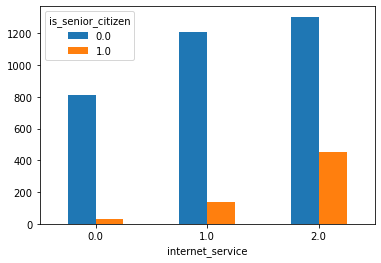

In [48]:
#let's look at the numbers visually
barplot = observed.plot.bar(rot=0)

### Take Aways:
* There IS a relationship between seniors and their internet service type accounts.
* The above barplot shows that a large majority of seniors have Fiber Optics for their internet service.

##########################################################################

# Internet type accounts vs. Singles:
Seeing what kind of internet accounts most single customers have.

* H0: There is NO relationship between internet type accounts and single Telco customers.
* Ha: There IS a relationship between internet type and single customer Telco customers.

In [49]:
#Calculating ChiSquare of categorical demographics (automated accounts + singles)
n = train.shape[0]

internet_service_proportions = train.internet_service.value_counts() / n
internet_service_proportions

2.0    0.445148
1.0    0.341272
0.0    0.213580
Name: internet_service, dtype: float64

In [50]:
single_proportions = train.partner_dependants.value_counts() / n
single_proportions

0    0.458829
3    0.255384
1    0.234102
2    0.051685
Name: partner_dependants, dtype: float64

In [51]:
expected = pd.DataFrame()

for internet_group, t_prop in internet_service_proportions.iteritems():
    for single_group, g_prop in single_proportions.iteritems():
        expected.loc[single_group, internet_group] = t_prop * g_prop

expected.sort_index(inplace=True)
expected

,2.0,1.0,0.0
0,0.204247,0.156586,0.097997
1,0.104210,0.079892,0.049999
2,0.023007,0.017639,0.011039
3,0.113684,0.087155,0.054545


In [52]:
# Chi squared with un-encoded categorical columns
alpha = 0.05
observed = pd.crosstab(train.internet_service, train.partner_dependants)
chi2, p, degf, expected = stats.chi2_contingency(observed)
print(f"The p-value is {p}")
if p < alpha:
    print("Sufficient evidence is present to reject the null hypothesis")
else:
    print("Insufficient evidence to reject the null")
    print("Evidence seems to support the claim that single customers and internet account types are independent")

The p-value is 1.2684922884363604e-34
Sufficient evidence is present to reject the null hypothesis


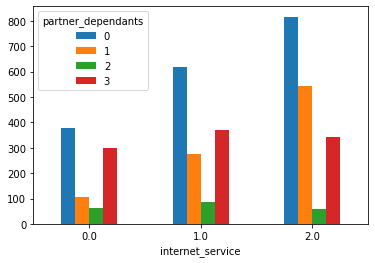

In [53]:
#let's look at the numbers visually
barplot = observed.plot.bar(rot=0)

### Take Aways:
* There IS a relationship between singles and their internet service type accounts.

##########################################################################

# BUT DOES INTERNET SERVICE RELATE TO CHURN???

- Now that we know our demographics and are seeing a relation to these same demographics to service types, let's just check that churn relates to the services these groups of customers hold:

## Churn vs Internet Service Type:

* H0: There is not relationship between Churn and Internet Service type.
* Ha: There is a relationship between Churn and Internet Service type.

In [54]:
#Calculating ChiSquare of categorical demographics (automated accounts + singles)
n = train.shape[0]

internet_service_proportions = train.internet_service.value_counts() / n
internet_service_proportions

2.0    0.445148
1.0    0.341272
0.0    0.213580
Name: internet_service, dtype: float64

In [55]:
churn_proportions = train.churn.value_counts() / n
churn_proportions

No     0.734735
Yes    0.265265
Name: churn, dtype: float64

In [56]:
expected = pd.DataFrame()

for internet_group, t_prop in internet_service_proportions.iteritems():
    for churn_group, g_prop in churn_proportions.iteritems():
        expected.loc[churn_group, internet_group] = t_prop * g_prop

expected.sort_index(inplace=True)
expected

,2.0,1.0,0.0
No,0.327066,0.250744,0.156925
Yes,0.118082,0.090527,0.056655


In [57]:
# Chi squared with un-encoded categorical columns
alpha = 0.05
observed = pd.crosstab(train.internet_service, train.churn)
chi2, p, degf, expected = stats.chi2_contingency(observed)
print(f"The p-value is {p}")
if p < alpha:
    print("Sufficient evidence is present to reject the null hypothesis")
else:
    print("Insufficient evidence to reject the null")
    print("Evidence seems to support the claim that churn and internet account types are independent")

The p-value is 7.732431681003518e-88
Sufficient evidence is present to reject the null hypothesis


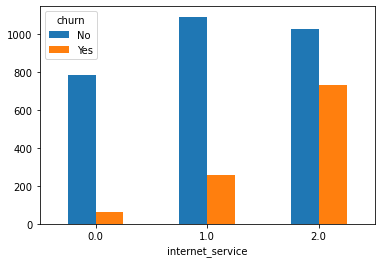

In [58]:
#let's look at the numbers visually
barplot = observed.plot.bar(rot=0)

### Take Aways:
* There IS a relationship between churn and their internet service type accounts.
* More accounts that had Fiber Optic for internet churned than any other internet service type.

##########################################################################

# My Drivers:
* DEMOGRAPHIC GROUPS-
    * Senior Citizens customers
    * Single customers
    
* ACCOUNT TYPE GROUPS-
    * Fiber Optic accounts
    * Non-automated accounts

- More visualizations to show these relationships:

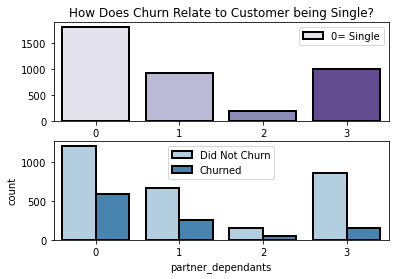

In [59]:
plt.subplot(211)

sns.countplot(x = 'partner_dependants', data=train, palette='Purples', ec='black', linewidth=2)

plt.title('How Does Churn Relate to Customer being Single?')
plt.xlabel('')
plt.ylabel('')
plt.legend(['0= Single'])
plt.subplot(212)

#countplot comparing partnership to churn
sns.countplot(x = 'partner_dependants', hue = 'churn', data=train, palette='Blues', ec='black', linewidth=2)

plt.legend(['Did Not Churn', 'Churned'])

plt.show()

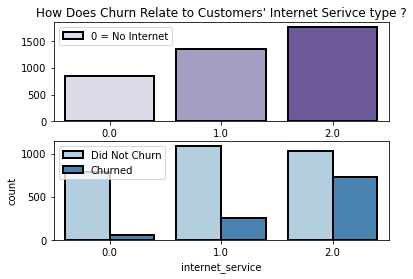

In [60]:
plt.subplot(211)

sns.countplot(x = 'internet_service', data=train, palette='Purples', ec='black', linewidth=2)

plt.title("How Does Churn Relate to Customers' Internet Serivce type ?")
plt.xlabel('')
plt.ylabel('')
plt.legend(['0 = No Internet',' 1 = DSL', '2 = Fiber'])
plt.subplot(212)

#countplot comparing partnership to churn
sns.countplot(x = 'internet_service', hue = 'churn', data=train, palette='Blues', ec='black', linewidth=2)

plt.legend(['Did Not Churn', 'Churned'])

plt.show()

# Onto ML Models:

### Creating Logistical Regression models:
To quickly assess and models with target (Churn) against chosen variables (Senior citizen, Single, Fiber Optics, non-automated accounts) into a Logistical Regression model. If the accuracy of this model is higher than my baseline, then I'll move onto other models. 

- Developing my baseline to compare my models to:    

In [61]:
#Taking freshly prepared data through the acquire and prepare.py files for modeling:
df = acquire.excel_file()
train, validate, test = prep_telco(df)

- Baseline (for the 'most common case to everything')

In [62]:
train.churn.value_counts(normalize=True)

No     0.734735
Yes    0.265265
Name: churn, dtype: float64

### My BASELINE IS 26% for accuracy (based on 'yes churn' data)

In [63]:
#filling the NaNs again for total_charges:
total_mean=train.total_charges.mean()
train['total_charges'].fillna(value=total_mean, inplace=True)

In [64]:
#Encoding data for later churn use (as right now it is an object and I need numeric for models)
# First I create a new dataframe that holds my encoded columns.

churn_dummies = pd.get_dummies(df.churn, drop_first=True)
churn_dummies.sample(5)

,Yes
654,0
3872,1
5756,0
5336,0
3724,0


- Defining my x and y:

In [65]:
train.head(1)

,gender,is_senior_citizen,partner,dependents,phone_service,internet_service,contract_type,payment_type,monthly_charges,total_charges,...,has_phone_internet,partner_dependants,calculated_monthly_avg,validate,phone_service_type,internet_service_type,contract_type.1,rounded_tenure,service_type,tenure_bins
2394,Male,0.0,Yes,No,1.0,1.0,1.0,Mailed check,54.35,1426.45,...,False,1,54.35,True,#REF!,#REF!,#REF!,26,Internet+Phone,2-3 years


In [90]:
# Dropping categorical and not-needed columns that are leftover.

X_train = train.drop(columns=['churn','gender', 'partner', 
                              'dependents', 'phone_service',
                              'payment_type','total_charges','has_phone_internet','calculated_monthly_avg',
                              'validate','phone_service_type','internet_service_type',
                             'contract_type.1','service_type','tenure_bins',
                             'tenure','is_female','Churned_Customers','has_phone','has_internet'])
y_train = train[['churn']]

X_validate = validate.drop(columns=['churn','gender', 'partner', 
                              'dependents', 'phone_service',
                              'payment_type','total_charges','has_phone_internet','calculated_monthly_avg',
                              'validate','phone_service_type','internet_service_type',
                             'contract_type.1','service_type','tenure_bins',
                             'tenure','is_female','Churned_Customers','has_phone','has_internet'])
y_validate = validate[['churn']]

X_test = test.drop(columns=['churn','gender', 'partner', 
                              'dependents', 'phone_service',
                              'payment_type','total_charges','has_phone_internet','calculated_monthly_avg',
                              'validate','phone_service_type','internet_service_type',
                             'contract_type.1','service_type','tenure_bins',
                             'tenure','is_female','Churned_Customers','has_phone','has_internet'])
y_test = test[['churn']]

### CREATING A LOGISTIC REGRESSION MODEL:::

In [91]:
# Create a simple Logistic Regression model to start.

logit = LogisticRegression(random_state=123)

#### FITTING THE LOGISTICAL REG. MODEL:

In [92]:
logit.fit(X_train, y_train)

LogisticRegression(random_state=123)

- Looking at coefficients to model:

In [93]:
# Create a list of our model features.

features = X_train.columns.tolist()

In [94]:
# Create a list of the weights for each feature from our model.

weights = logit.coef_.flatten()

In [95]:
# Store our lists from above in a DataFrame.

pd.DataFrame(weights, features).reset_index().rename(columns={'index': 'feature', 0: 'weight'})

,feature,weight
0,is_senior_citizen,0.403336
1,internet_service,0.869941
2,contract_type,-0.821560
3,monthly_charges,0.005442
4,is_auto,-0.328143
5,partner_dependants,-0.052999
6,rounded_tenure,-0.027139


### Evaluating Model:

In [96]:
#Accuracy of the models logistic classifier
print('Accuracy of Logistic Regression classifier on training set: {:.2f}'
     .format(logit.score(X_train, y_train)))

Accuracy of Logistic Regression classifier on training set: 0.79


- Evaluating with classification report:

In [97]:
#making predictions on whether customer churns or not
y_pred = logit.predict(X_train)

In [98]:
#estimating probability of churn based on observations
y_pred_proba = logit.predict_proba(X_train)

In [99]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

          No       0.83      0.90      0.86      2900
         Yes       0.63      0.48      0.55      1047

    accuracy                           0.79      3947
   macro avg       0.73      0.69      0.70      3947
weighted avg       0.77      0.79      0.78      3947



### TAKE AWAY:
- The first model is already classifying higher than our baseline, so I am on a good track. 
- My recall number is fairly high, so this model was good at predicting TP (aka good at predicting churning)
- 
- 

# Decision Tree Model:

Fitting the decision tree classifier to the Telco training sample and transform (i.e. make predictions on the training sample)

In [114]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
#creating that decision tree!

tree1= DecisionTreeClassifier(max_depth=2, random_state=123)

In [115]:
# model.fit(X, y)
tree1 = tree1.fit(X_train, y_train)

[Text(390.6, 317.09999999999997, 'contract_type <= 0.5\ngini = 0.39\nsamples = 3947\nvalue = [2900, 1047]\nclass = No'),
 Text(195.3, 190.26, 'internet_service <= 1.5\ngini = 0.489\nsamples = 2146\nvalue = [1229, 917]\nclass = No'),
 Text(97.65, 63.420000000000016, 'gini = 0.409\nsamples = 947\nvalue = [676, 271]\nclass = No'),
 Text(292.95000000000005, 63.420000000000016, 'gini = 0.497\nsamples = 1199\nvalue = [553, 646]\nclass = Yes'),
 Text(585.9000000000001, 190.26, 'monthly_charges <= 93.775\ngini = 0.134\nsamples = 1801\nvalue = [1671, 130]\nclass = No'),
 Text(488.25, 63.420000000000016, 'gini = 0.079\nsamples = 1351\nvalue = [1295, 56]\nclass = No'),
 Text(683.5500000000001, 63.420000000000016, 'gini = 0.275\nsamples = 450\nvalue = [376, 74]\nclass = No')]

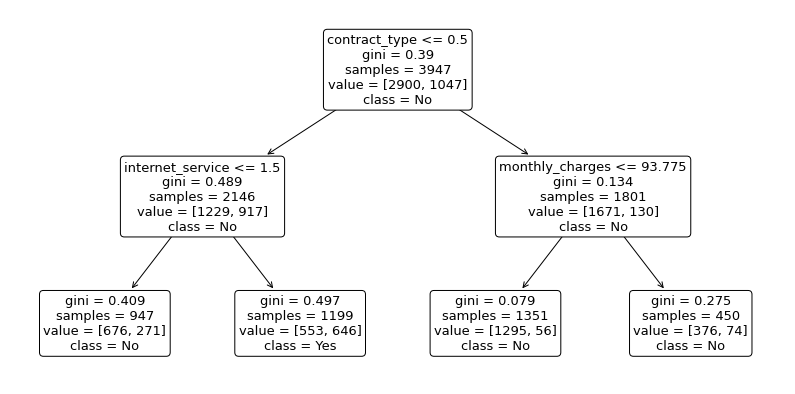

In [116]:
#plot the tree
plt.figure(figsize=(14, 7))
plot_tree(tree1, feature_names=X_train.columns, class_names=clf.classes_.astype(str), rounded=True)

In [103]:
### Make Predictions
y_pred=clf.predict(X_train)
y_pred[0:5]

array(['No', 'No', 'No', 'No', 'No'], dtype=object)

In [104]:
### Estimate Probability
y_pred_proba=clf.predict_proba(X_train)
y_pred_proba[0:5]

array([[0.95854922, 0.04145078],
       [0.83555556, 0.16444444],
       [0.71383316, 0.28616684],
       [0.83555556, 0.16444444],
       [0.83555556, 0.16444444]])

#### EVALUATING DECISION TREE MODEL:

In [105]:
print('Accuracy of Decision Tree classifier on Telco training set: {:.2f}'
      .format(clf.score(X_train, y_train)))

Accuracy of Decision Tree classifier on Telco training set: 0.76


In [106]:
# let's evaluate using a confusion matrix
confusion_matrix(y_train, y_pred)

array([[2347,  553],
       [ 401,  646]])

In [107]:
#to see a visual of how many 'No churns' vs 'Yes churns' in this model:
y_train.value_counts()

churn
No       2900
Yes      1047
dtype: int64

In [108]:
#creating a dataframe to see the matrix/needed to rename as variables were still 0 and 1
labels = ('Not Churn 0', 'Churn 1')

pd.DataFrame(confusion_matrix(y_train, y_pred), index=labels, columns=labels)

,Not Churn 0,Churn 1
Not Churn 0,2347,553
Churn 1,401,646


In [109]:
#I'll use a classification to evaluate this model:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

          No       0.85      0.81      0.83      2900
         Yes       0.54      0.62      0.58      1047

    accuracy                           0.76      3947
   macro avg       0.70      0.71      0.70      3947
weighted avg       0.77      0.76      0.76      3947



In [110]:
#To find the accuracy, TP, FP, TN, and FN on this model:
TP = 2347
FP = 401
FN = 553
TN = 646
ALL = TP + FP + FN + TN

In [111]:
accuracy = (TP + TN)/ALL
print(f"Accuracy: {accuracy}")

true_positive_rate = TP/(TP+FN)
print(f"True Positive Rate: {true_positive_rate}")

false_positive_rate = FP/(FP+TN)
print(f"False Positive Rate: {false_positive_rate}")

true_negative_rate = TN/(TN+FP)
print(f"True Negative Rate: {true_negative_rate}")

false_negative_rate = FN/(FN+TP)
print(f"False Negative Rate: {false_negative_rate}")

precision = TP/(TP+FP)
print(f"Precision: {precision}")

recall = TP/(TP+FN)
print(f"Recall: {recall}")

f1_score = 2*(precision*recall)/(precision+recall)
print(f"F1 Score: {f1_score}")

support_pos = TP + FN
print(f"Support (0): {support_pos}")

support_neg = FP + TN
print(f"Support (1): {support_neg}")

Accuracy: 0.7582974410945021
True Positive Rate: 0.8093103448275862
False Positive Rate: 0.38299904489016234
True Negative Rate: 0.6170009551098377
False Negative Rate: 0.1906896551724138
Precision: 0.854075691411936
Recall: 0.8093103448275862
F1 Score: 0.8310906515580737
Support (0): 2900
Support (1): 1047


In [112]:
# I'll create a "for" loop so that multiple models can be tested out:
for i in range(2, 21):
    # Make the model
    tree = DecisionTreeClassifier(max_depth=i, random_state=123)

    # Fit the model (on train and only train)
    tree = tree.fit(X_train, y_train)

    # Use the model
    # We'll evaluate the model's performance on train, first
    y_predictions = tree.predict(X_train)

    # Produce the classification report on the actual y values and this model's predicted y values
    report = classification_report(y_train, y_predictions, output_dict=True)
    print(f"Tree with max depth of {i}")
    print(pd.DataFrame(report))
    print()

Tree with max depth of 2
                    No          Yes  accuracy    macro avg  weighted avg
precision     0.854076     0.538782  0.758297     0.696429      0.770439
recall        0.809310     0.617001  0.758297     0.713156      0.758297
f1-score      0.831091     0.575245  0.758297     0.703168      0.763224
support    2900.000000  1047.000000  0.758297  3947.000000   3947.000000

Tree with max depth of 3
                    No          Yes  accuracy    macro avg  weighted avg
precision     0.799415     0.685009   0.78414     0.742212      0.769067
recall        0.942759     0.344795   0.78414     0.643777      0.784140
f1-score      0.865190     0.458704   0.78414     0.661947      0.757363
support    2900.000000  1047.000000   0.78414  3947.000000   3947.000000

Tree with max depth of 4
                    No          Yes  accuracy    macro avg  weighted avg
precision     0.826182     0.652520  0.793007     0.739351      0.780116
recall        0.909655     0.469914  0.793007  

### Validate the model:
- comparing in-sample to out-of-sample

In [119]:
metrics = []

for i in range(2, 25):
    # Make the model
    tree = DecisionTreeClassifier(max_depth=i, random_state=123)

    # Fit the model (on train and only train)
    tree = tree.fit(X_train, y_train)

    # Use the model
    # We'll evaluate the model's performance on train, first
    in_sample_accuracy = tree.score(X_train, y_train)
    
    out_of_sample_accuracy = tree.score(X_validate, y_validate)

    output = {
        "max_depth": i,
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy
    }
    
    metrics.append(output)
    

In [120]:
val_df = pd.DataFrame(metrics)
val_df["difference"] = val_df.train_accuracy - val_df.validate_accuracy
val_df

,max_depth,train_accuracy,validate_accuracy,difference
0,2,0.758297,0.764775,-0.006478
1,3,0.784140,0.791371,-0.007231
2,4,0.793007,0.795508,-0.002501
3,5,0.802635,0.788416,0.014219
4,6,0.811756,0.779551,0.032205
5,7,0.823664,0.763593,0.060070
6,8,0.833291,0.765957,0.067334
7,9,0.850519,0.761820,0.088699
8,10,0.872055,0.747045,0.125010
9,11,0.887510,0.746454,0.141056


### TAKE AWAYS:
- The model with the highest accuracy is the DT with a max depth of 20...the higher it goes, the more accurate it shows, however this kind of test is more prone to over-fitting the data in the model. 
- I would choose a model with a mid range accuracy (around 80+ accuracy and >0.07 for difference)
- <b>My choice here would be going with model 7 and it fits within the boundaries I listed and there is not a significant increase of difference there.</b>